In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [222]:
def gen_dataset(f, noise, N, dom=[10, 90]):
    X = np.linspace(dom[0], dom[1], N)
    Y = f(np.copy(X))
    X += np.random.uniform(-noise, noise, N)
    Y += np.random.uniform(-noise, noise, N)
    return np.vstack([X, Y])

def summary_statistics(data):
    X, Y = data[0, :], data[1, :]
    return np.array([
        np.mean(X),
        np.mean(Y),
        np.std(X),
        np.std(Y),
        np.corrcoef(X, Y)[0, 1]
    ])

def plot(data, title=None, plot_summary=True):
    X, Y = data[0, :], data[1, :]
    plt.scatter(X, Y)
    if plot_summary:
        x_mean, y_mean, x_std, y_std, r = summary_statistics(data)
        plt.text(105, 90,
                 f"X Mean: {x_mean:.2f}\nY Mean: {y_mean:.2f}\nX Std: {x_std:.2f}\nY Std: {y_std:.2f}\nR: {r:.2f}",
                 verticalalignment="top")
    if title is not None:
        plt.title(title)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect("equal")
    plt.show()

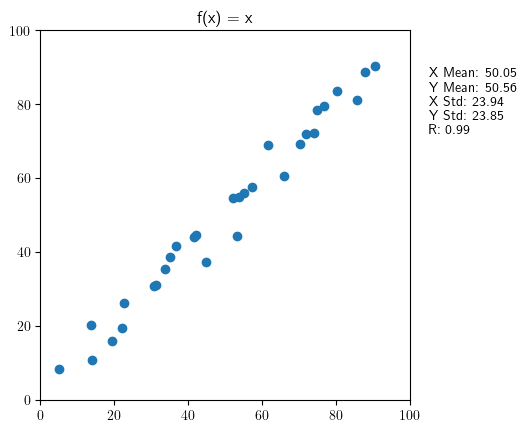

In [214]:
data = gen_dataset(lambda x: x, 5, 30)
plot(data, title="f(x) = x")

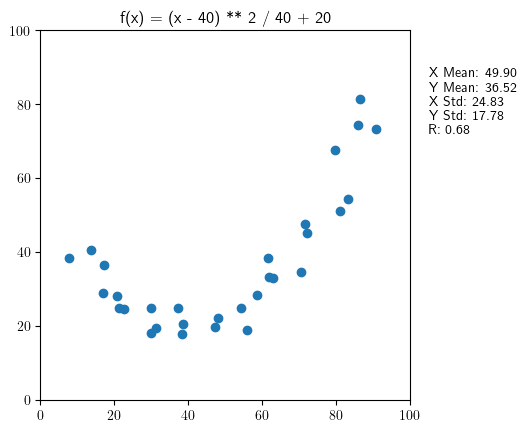

In [217]:
data = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 5, 30)
plot(data, title="f(x) = (x - 40) ** 2 / 40 + 20")

In [220]:
def data_dist(data1, data2):
    dists = cdist(data1, data2)
    row_i, col_i = linear_sum_assignment(dists)
    return np.sum(dists[row_i, col_i])

In [223]:
data1 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
dist = data_dist(data1, data2)
print("Distance between similar datasets:", dist)

data1 = gen_dataset(lambda x: x, 1, 30)
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
dist = data_dist(data1, data2)
print("Distance between different datasets:", dist)

data1 = gen_dataset(lambda x: x, 1, 30, dom=[10, 50])
data2 = gen_dataset(lambda x: x, 1, 30, dom=[50, 90])
dist = data_dist(data1, data2)
print("Distance between different domains:", dist)

Distance between similar datasets: 9.114395178263493
Distance between different datasets: 123.67054635846564
Distance between different domains: 439.63990223719964
